<h2> Imports </h2>

In [46]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import burr
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats.stats import pearsonr, spearmanr
import math
from scipy import stats
from scipy.spatial import distance
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
import warnings
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression, RFE
from sklearn.metrics.cluster import normalized_mutual_info_score
warnings.filterwarnings("ignore")

<h2> Helper Methods </h2>

In [47]:
## Generate lags for all input features, re-generate even if some exist so that order will not be shuffled after nan dropping
def generate_lags_for(df, column, lags_count):
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
        return df

def generate_lags(df, lagsForColumns):
    '''This function generates the lags for the list of columns'''
    for k in range(len(lagsForColumns)):
        col = lagsForColumns[k]
        if col in df.columns:
            df = generate_lags_for(df, col, 5)
    return df

def split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    
    unique_sites = df["Site Id"].unique()
    print("Number of sites:", len(unique_sites))

    for site in unique_sites:
        df_site = df[df["Site Id"] == site]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:], ignore_index = True)
        Y_train = Y_train.append(X[:train_index], ignore_index = True)
        Y_test = Y_test.append(X[train_index:], ignore_index = True)
   
    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
   
    X_train = X_train.drop([output_column], axis = 1)
    X_test = X_test.drop([output_column], axis = 1)
   
    return X_train, X_test, Y_train, Y_test

    
def get_accurate_prediction_score(y_test, y_pred):
    ratio = np.abs(y_test - y_pred) / y_test
    return ratio


#calculates all error metrics needed
def calculate_errors(y_test, y_pred, nb_columns):
    n = len(y_test)
    r2_Score = r2_score(y_test, y_pred)  # r-squared
    adjusted_r2 = 1 - ((1 - r2_Score) * (n - 1)) / (n - nb_columns - 1)  # adjusted r-squared
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
    mse_score = mean_squared_error(y_test, y_pred)  # MSE
    mae_score = mean_absolute_error(y_test, y_pred)  # MAE
    mape_score = np.asarray(np.abs(( np.array(y_test) - np.array(y_pred)) / np.array(y_test)), dtype=np.float64).mean() * 100  # MAPE
    pearson_corr, _ = pearsonr(np.array(y_test).ravel(), np.array(y_pred).ravel())
    spearman_corr, _ = spearmanr(np.array(y_test).ravel(), np.array(y_pred).ravel())
    distance_corr = distance.correlation(np.array(y_test).ravel(), np.array(y_pred).ravel())
    acc = 100 - mape_score
    nmi = normalized_mutual_info_score(np.array(y_test).ravel(), np.array(y_pred).ravel())
    aic = n * np.log(mse_score)
    bic = n * np.log(mse_score)
    print('\nRegression Error Metrics')
    print('R2: %.5f' % r2_Score)
    print('Adj-R2: %.5f' % adjusted_r2)
    print('RMSE: %.5f' % rmse_score)
    print('MSE: %.5f' % mse_score)
    print('MAE: %.5f' % mae_score)
    print('MAPE: %.5f' % mape_score)
    print('Accuracy: %.5f' % acc)
    print('\nCorrelations')
    print('Pearson: %.5f' % pearson_corr)
    print('Spearman: %.5f' % spearman_corr)
    print('Distance: %.5f' % distance_corr)
    
    print('\nExtra')
    print('NMI: %.5f' % nmi)
    print('AIC: %.5f' % aic)
    print('BIC: %.5f' % bic)
    
    
def gen_xspan(mean, std, n=2, num=100):
#Generate span for x axis to plot the probabilty distribution
    return np.linspace(mean - n * std, mean + n * std, num)

def normalize_ticks(ax):
    cln_ticks = lambda t: float(t.replace("−", "-"))
    get_ticks = lambda ax: list(
        map(cln_ticks, [item.get_text() for item in ax.get_yticklabels()])
    )
    labels = get_ticks(ax)
    labels = [f"{l / np.max(labels):.3f}" for l in labels]
    ax.set_yticklabels(labels)
    return ax

def heavyside(thresholds, actual):
    # Given a deterministic observation, make a CDF out of it
    result = [1 if t >= actual else 0 for t in thresholds]
    return result

def is_cdf_valid(case):
    if case[0] < 0 or case[0] > 1:
        return False
    for i in xrange(1, len(case)):
        if case[i] > 1 or case[i] < case[i-1]:
            return False
    return True

# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2, 10):
        rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=i)
        model = GradientBoostingRegressor(n_estimators=35, random_state= 10, min_samples_split=90, min_samples_leaf=60, max_features=0.5, max_depth=4, learning_rate=0.1, subsample= 0.6)
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, cv=cv)
    return scores

def calc_crps(thresholds, predictions, actuals):
    nthresh = len(thresholds)  # 70 in example
    ncases  = len(predictions)
    crps = 0
    for case, actual in zip(predictions, actuals):
        if (len(case) == nthresh) and is_cdf_valid(case):
            obscdf = heavyside(thresholds, actual)
            for fprob, oprob in zip(case, obscdf):
                crps = crps + (fprob - oprob)*(fprob - oprob)
        else:
            crps = crps + nthresh  # treat delta at each threshold as 1
    crps = crps / float(ncases * nthresh)

<h2> Read Data</h2>

In [48]:
input_path = "/Users/saraawad/Desktop/All_Manual_Daily_Albedo_NDVI_LST_Cleaned.csv"
df = pd.read_csv(input_path, delimiter=',')
output_column ='LE_bowen_corr(mm)'
df.head()

Date Site Id  Year  Month  Day Climate Vegetation  Latitude  \
0  2000-03-27  FI-Jok  2000      3   27   Other        CRO   60.8986   
1  2000-04-16  FI-Jok  2000      4   16   Other        CRO   60.8986   
2  2000-04-29  FI-Jok  2000      4   29   Other        CRO   60.8986   
3  2000-04-30  FI-Jok  2000      4   30   Other        CRO   60.8986   
4  2000-05-01  FI-Jok  2000      5    1   Other        CRO   60.8986   

   Longitude  Site Id_1  ...  EEflux NDVI-2  EEflux NDVI-3  EEflux NDVI-4  \
0   23.51345          1  ...            NaN            NaN            NaN   
1   23.51345          1  ...            NaN            NaN            NaN   
2   23.51345          1  ...         -0.053            NaN            NaN   
3   23.51345          1  ...          0.316         -0.053            NaN   
4   23.51345          1  ...          0.413          0.316         -0.053   

   EEflux NDVI-5  EEflux Albedo  EEflux Albedo-1  EEflux Albedo-2  \
0            NaN          0.507              NaN              NaN   
1            NaN          0.110            0.507              NaN   
2            NaN          0.121            0.110            0.507   
3            NaN          0.121            0.121            0.110   
4            NaN          0.122            0.121            0.121   

   EEflux Albedo-3  EEflux Albedo-4  EEflux Albedo-5  
0              NaN              NaN              NaN  
1              NaN              NaN              NaN  
2              NaN              NaN              NaN  
3            0.507              NaN              NaN  
4            0.110            0.507              NaN  

[5 rows x 107 columns]

<h2> Drop Columns </h2>

In [49]:
columnsToDrop = ['Date', 'Year', 'Month', 'Day', 'Site Id_1', 'Site Id_2', 'Site Id_3',
                        'Site Id_4', 'Site Id_5', 'Site Id_6','Vegetation', 'Latitude', 'Longitude', 'Climate',
                        'G','G-1','G-2','G-3','G-4','G-5',
                        'Climate_1', 'Climate_2', 'Climate_3',
                        'Latitude_1','Latitude_2', 'Latitude_3', 'Latitude_4', 'Latitude_5',
                        'Latitude_6','Longitude_1', 'Longitude_2', 'Longitude_3', 'Longitude_4',
                        'Longitude_5', 'Longitude_6',
                        'H', 'H_bowen_corr', 'H_bowen_corr-1', 'H_bowen_corr-2', 'H_bowen_corr-3', 'H_bowen_corr-4',
                        'H_bowen_corr-5', 'C_BOWENS',
                        'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
                        'LE', 'LE_bowen_corr',
                        'Elevation(m)_1','Elevation(m)_2', 'Elevation(m)_3', 'Elevation(m)_4',
                        'Elevation(m)_5', 'Elevation(m)_6',
                        'ETo', 'EToF', 'ETr', 'ETrF', 'ETo', 'SW_IN']

<h2> Data Preprocessing </h2>

In [50]:
#drop na
df.dropna(inplace=True)

#set output variable between 1 and 15 only
df = df[df[output_column].between(1, 15)]

#drop desired columns, rename, and drop the nans
df = df.drop(columnsToDrop, axis = 1)
df.dropna(inplace=True)

#generate lags for columns
lagsForColumns = ["WS", "RH", "TA", "EEflux_LST", "EEflux_Albedo", "EEflux_NDVI", "SW_IN"]
df = generate_lags(df, lagsForColumns)

#drop nan for the first 5 rows of the generated lags only 5 rows will be removed in here
df.isnull().mean() * 10
df.dropna(inplace=True)
print(df.shape)
print("checking null values in the whole dataset")
print(df.isnull().values.any())
print(df.columns)
#df[output_column] = df['ET_bowen_corr_mm'] / df['ETo']
#df = df.drop(['ET_bowen_corr_mm', 'ETo'], axis=1)
df.dropna(inplace=True)


(10911, 45)
checking null values in the whole dataset
False
Index(['Site Id', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2', 'WS-3', 'WS-4',
       'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5', 'TA', 'TA-1',
       'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr(mm)', 'EEflux LST',
       'EEflux LST-1', 'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4',
       'EEflux LST-5', 'EEflux NDVI', 'EEflux NDVI-1', 'EEflux NDVI-2',
       'EEflux NDVI-3', 'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux Albedo',
       'EEflux Albedo-1', 'EEflux Albedo-2', 'EEflux Albedo-3',
       'EEflux Albedo-4', 'EEflux Albedo-5'],
      dtype='object')


In [51]:
print(np.array(df['LE_bowen_corr(mm)']).mean())

3.7471547625276562


<h2> Split Data </h2>

In [52]:
#split into train and test according to special split
X_train, X_test, Y_train, Y_test = split_train_test_valid(df, 0.8, 0.2)

X_train = X_train.drop('Site Id', axis = 1)
X_test = X_test.drop('Site Id', axis = 1)
columns = X_train.columns
X_train.columns
print(len(columns))

Number of sites: 26
43


# RFE

In [53]:
# create pipeline
# Note: Decision tree is used
rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=38)
model = GradientBoostingRegressor(n_estimators=35, random_state= 10, min_samples_split=90, min_samples_leaf=60, max_features=0.5, max_depth=4, learning_rate=0.1, subsample= 0.6)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_train, Y_train, scoring='r2', cv=cv)

In [54]:
# report performance
print('R2: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

R2: 0.584 (0.012)


## RFE Tuning

In [55]:
# //Note: why start with 30?
# //end in total number of features?
num_features = np.arange(30,43,1)
results, names = list(), list()
for num in num_features:
    print(str(num) + " features")
    # create pipeline
    rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=num)
    model = GradientBoostingRegressor(n_estimators=35, random_state= 10, min_samples_split=90, min_samples_leaf=60, max_features=0.5, max_depth=4, learning_rate=0.1, subsample= 0.6)
    pipeline = Pipeline(steps=[('s',rfe),('m',model)])
    # evaluate model
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    n_scores = cross_val_score(pipeline, X_train, Y_train, scoring='r2', cv=cv)
    results.append(n_scores)
    names.append(num)
    print('R2: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

30 features
R2: 0.585 (0.011)
31 features
R2: 0.583 (0.013)
32 features
R2: 0.584 (0.012)
33 features
R2: 0.584 (0.011)
34 features
R2: 0.584 (0.012)
35 features
R2: 0.584 (0.012)
36 features
R2: 0.584 (0.012)
37 features
R2: 0.585 (0.010)
38 features
R2: 0.583 (0.012)
39 features
R2: 0.586 (0.011)
40 features
R2: 0.584 (0.011)
41 features
R2: 0.585 (0.011)
42 features
R2: 0.582 (0.013)


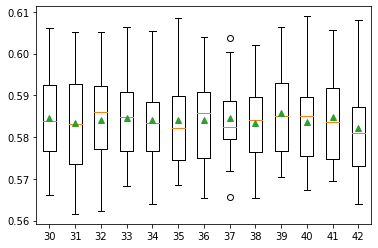

In [56]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Which features are actually selected

In [57]:

# define RFE
rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=num)
# fit RFE
rfe.fit(X_train, Y_train)
# summarize all features
for i in range(X_train.shape[1]):
    print('Column: %d, Selected=%s, Rank: %d' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected=True, Rank: 1
Column: 1, Selected=True, Rank: 1
Column: 2, Selected=True, Rank: 1
Column: 3, Selected=True, Rank: 1
Column: 4, Selected=True, Rank: 1
Column: 5, Selected=True, Rank: 1
Column: 6, Selected=True, Rank: 1
Column: 7, Selected=True, Rank: 1
Column: 8, Selected=True, Rank: 1
Column: 9, Selected=True, Rank: 1
Column: 10, Selected=True, Rank: 1
Column: 11, Selected=True, Rank: 1
Column: 12, Selected=True, Rank: 1
Column: 13, Selected=True, Rank: 1
Column: 14, Selected=True, Rank: 1
Column: 15, Selected=True, Rank: 1
Column: 16, Selected=True, Rank: 1
Column: 17, Selected=True, Rank: 1
Column: 18, Selected=True, Rank: 1
Column: 19, Selected=True, Rank: 1
Column: 20, Selected=True, Rank: 1
Column: 21, Selected=True, Rank: 1
Column: 22, Selected=True, Rank: 1
Column: 23, Selected=True, Rank: 1
Column: 24, Selected=True, Rank: 1
Column: 25, Selected=True, Rank: 1
Column: 26, Selected=True, Rank: 1
Column: 27, Selected=True, Rank: 1
Column: 28, Selected=True, Ran